# Overview

Here we are simply trying to minimize the root mean square error for predicting the 16th, 50th, 84th percentile [O/H] and 50th percentile of the stellar mass.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
torch.cuda.set_device(2)

In [3]:
PATH = os.path.abspath('..')

In [4]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's do it

In [37]:
train_label_csv = f'{PATH}/catalogs/train-mass-metal.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [40]:
sz = 128
bs = 128
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-mass-metal', num_workers=8)

In [41]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [42]:
df.describe()

,oh_p16,oh_p50,oh_p84,lgm_tot_p50
count,95986.000000,95986.000000,95986.000000,95986.000000
mean,8.858187,8.906781,8.951449,10.012809
std,0.231597,0.199232,0.179088,0.560161
min,7.771679,7.851740,7.907599,6.140463
25%,8.746622,8.809235,8.846242,9.646171
50%,8.925781,8.955896,8.992349,10.058685
75%,9.015585,9.054318,9.085357,10.422712
max,9.463200,9.469999,9.476800,12.483970


In [43]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 82%|████████▏ | 979/1200 [01:17<00:17, 12.56it/s, loss=1.67] 

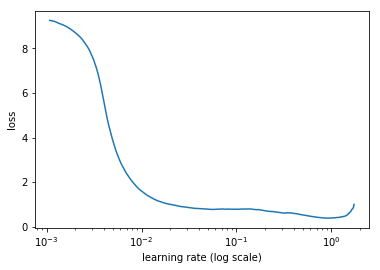

In [44]:
learn.lr_find(start_lr=1e-3)
learn.sched.plot()

# Begin training

Here we will try defining specific learning rate phases, as described by [Sylvain Gugger](https://github.com/fastai/fastai/blob/master/courses/dl2/training_phase.ipynb)

In [45]:
lr = 0.1
learn.fit(lr, n_cycle=1, cycle_len=1)

 82%|████████▏ | 979/1200 [01:35<00:21, 10.22it/s, loss=1.67]

epoch      trn_loss   val_loss                                 
    0      0.274872   0.240984  


[array([0.24098])]

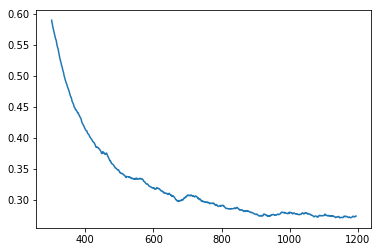

In [47]:
learn.sched.plot_loss(n_skip=300)

In [49]:
learn.fit(lr, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.245833   0.233329  


[array([0.23333])]

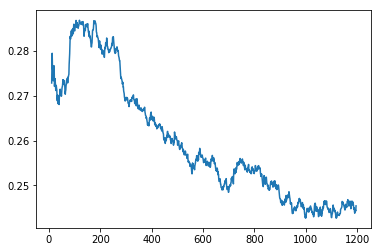

In [50]:
learn.sched.plot_loss()

In [52]:
learn.save('resnet34_mass-metal_sz128-bs128_init')

## Unfreeze early layers

### Begin differential learning with annealed learning rate

In [53]:
learn.unfreeze()
lrs = 1e-2 * np.array([1e-2, 1e-1, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.197856   0.189447  
    1      0.176862   0.170419                                 
    2      0.175883   0.167905                                 
    3      0.169602   0.162096                                 
    4      0.167781   0.157846                                 
    5      0.169181   0.158147                                 
    6      0.166831   0.157194                                 


[array([0.15719])]

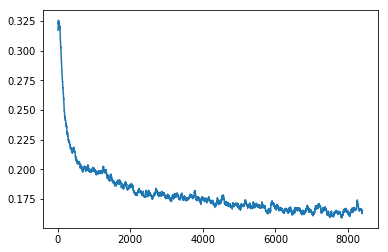

In [54]:
learn.sched.plot_loss()

~20 minutes

In [55]:
learn.save('resnet34_mass-metal_sz128-bs128_diff-1')
#learn.load('resnet34_mass-metal_sz128-bs128_diff-1')

In [ ]:
p_val, y_val = learn.TTA()
pred_val = np.mean(p_val, axis=0)

rms_errors = np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

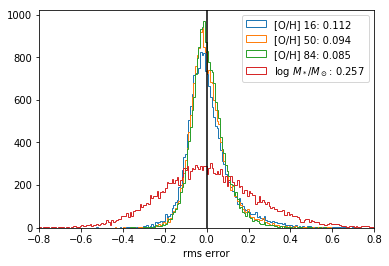

In [59]:
for i in range(4):
    plt.hist(pred_val[:, i]-y_val[:, i], bins=200, histtype='step', range=[-0.8, 0.8]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['[O/H] 16', '[O/H] 50', '[O/H] 84', r'log $M_*/M_\odot$'], rms_errors)]);
plt.xlim(-0.8, 0.8)
plt.axvline(0, c='k')
plt.xlabel('rms error');

# Results and evaluation

## Lowest metallicity (50th percentile)

Prediction: 8.261, True: 8.276, error: 0.014


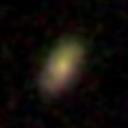

Prediction: 8.274, True: 8.022, error: 0.252


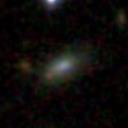

Prediction: 8.290, True: 8.123, error: 0.167


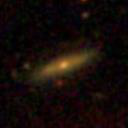

Prediction: 8.292, True: 8.116, error: 0.176


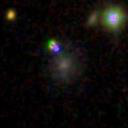

Prediction: 8.298, True: 8.222, error: 0.076


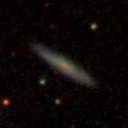

In [65]:
for idx in np.argsort(pred_val[:, 1])[:5]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Highest metallicity (50th percentile) 

Prediction: 9.179, True: 9.145, error: 0.034


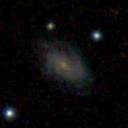

Prediction: 9.172, True: 9.128, error: 0.044


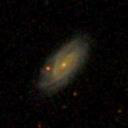

Prediction: 9.169, True: 9.184, error: 0.015


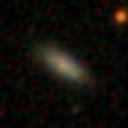

Prediction: 9.167, True: 9.171, error: 0.004


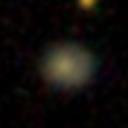

Prediction: 9.166, True: 9.170, error: 0.004


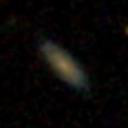

In [67]:
for idx in list(reversed(np.argsort(pred_val[:, 1])))[:5]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Most uncertain metallicity (50th percentile)

Prediction: 8.908, True: 7.955, error: 0.952


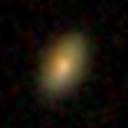

Prediction: 9.030, True: 8.323, error: 0.707


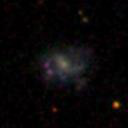

Prediction: 9.067, True: 8.363, error: 0.704


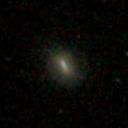

Prediction: 9.099, True: 8.462, error: 0.637


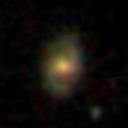

Prediction: 9.053, True: 8.431, error: 0.622


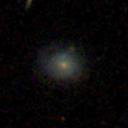

Prediction: 8.991, True: 8.386, error: 0.606


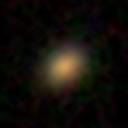

Prediction: 8.831, True: 9.432, error: 0.601


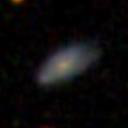

Prediction: 9.041, True: 8.446, error: 0.595


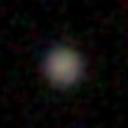

Prediction: 9.006, True: 8.416, error: 0.590


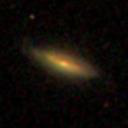

Prediction: 9.072, True: 8.482, error: 0.590


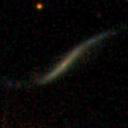

In [69]:
for idx in list(reversed(np.argsort((pred_val[:, 1] - y_val[:, 1])**2)))[:10]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Lowest stellar mass

Prediction: 8.611, True: 8.340, error: 0.270


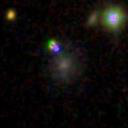

Prediction: 8.615, True: 8.347, error: 0.268


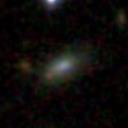

Prediction: 8.622, True: 8.387, error: 0.234


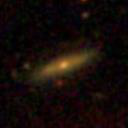

Prediction: 8.644, True: 8.355, error: 0.290


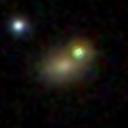

Prediction: 8.645, True: 8.424, error: 0.221


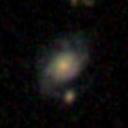

In [71]:
for idx in np.argsort(pred_val[:, 3])[:5]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Highest stellar mass

Prediction: 11.069, True: 11.442, error: 0.373


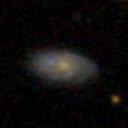

Prediction: 11.065, True: 11.192, error: 0.126


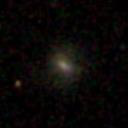

Prediction: 11.062, True: 11.173, error: 0.111


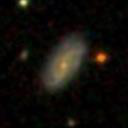

Prediction: 11.059, True: 11.404, error: 0.345


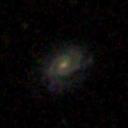

Prediction: 11.055, True: 11.667, error: 0.612


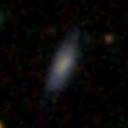

In [70]:
for idx in list(reversed(np.argsort(pred_val[:, 3])))[:5]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Most uncertain stellar mass

Prediction: 10.117, True: 7.950, error: 2.167
Pred metallicity: 8.995, True metallicity: 9.058, error: -0.063


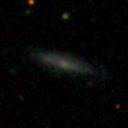

Prediction: 9.323, True: 11.462, error: -2.139
Pred metallicity: 8.704, True metallicity: 9.173, error: -0.469


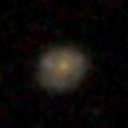

Prediction: 10.241, True: 8.234, error: 2.007
Pred metallicity: 8.987, True metallicity: 9.049, error: -0.062


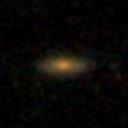

Prediction: 9.455, True: 7.472, error: 1.982
Pred metallicity: 8.704, True metallicity: 8.660, error: 0.044


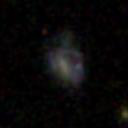

Prediction: 10.189, True: 8.356, error: 1.834
Pred metallicity: 9.063, True metallicity: 9.050, error: 0.013


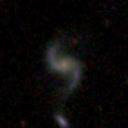

Prediction: 10.266, True: 12.060, error: -1.794
Pred metallicity: 9.032, True metallicity: 9.066, error: -0.035


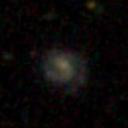

Prediction: 8.946, True: 7.201, error: 1.745
Pred metallicity: 8.450, True metallicity: 8.526, error: -0.076


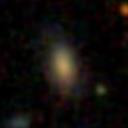

Prediction: 10.228, True: 8.542, error: 1.686
Pred metallicity: 8.952, True metallicity: 8.878, error: 0.075


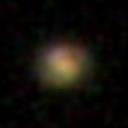

Prediction: 9.633, True: 11.306, error: -1.673
Pred metallicity: 8.768, True metallicity: 8.569, error: 0.199


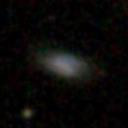

Prediction: 10.243, True: 8.623, error: 1.621
Pred metallicity: 9.107, True metallicity: 9.130, error: -0.023


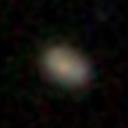

In [85]:
for idx in list(reversed(np.argsort((pred_val[:, 3] - y_val[:, 3])**2)))[10:20]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, p-y))
    print('Pred metallicity: {:.3f}, True metallicity: {:.3f}, error: {:.3f}'.format(pred_val[idx, 1], y_val[idx, 1], pred_val[idx, 1] -  y_val[idx, 1]))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

## Correlation of errors:


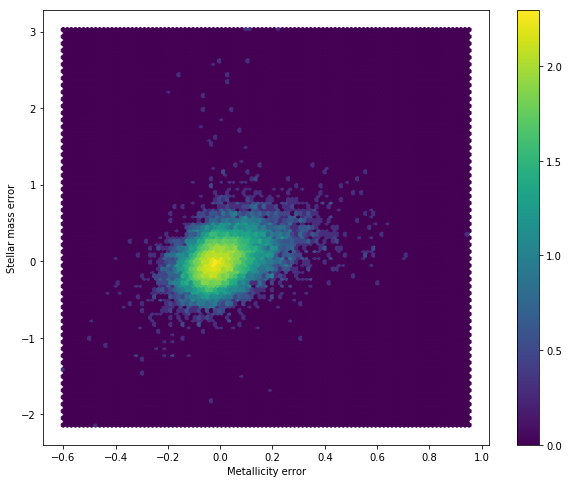

In [92]:
p_met = pred_val[:, 1]
y_met = y_val[:, 1]
p_mass = pred_val[:, 3]
y_mass = y_val[:, 3]

plt.figure(figsize=(10, 8))
plt.hexbin(p_met - y_met, p_mass - y_mass, bins='log')
plt.xlabel('Metallicity error')
plt.ylabel('Stellar mass error')
plt.colorbar();

## Mass and metallcitiy pdfs

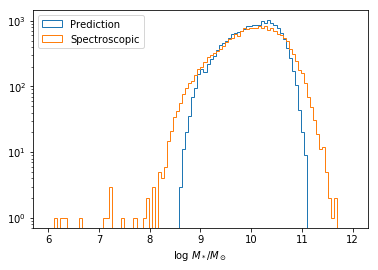

In [81]:
plt.hist(pred_val[:, 3], range=[6, 12], bins=100, histtype='step', label='Prediction')
plt.hist(y_val[:, 3], range=[6, 12], bins=100, histtype='step', label='Spectroscopic')
plt.xlabel(r'log $M_*/M_\odot$')
plt.yscale('log')
plt.legend(loc='upper left');

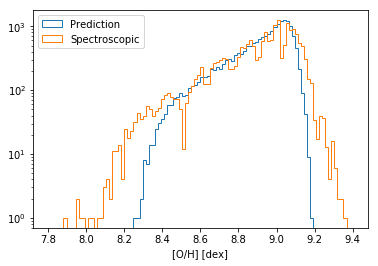

In [94]:
plt.hist(pred_val[:, 1], range=[7.8, 9.4], bins=100, histtype='step', label='Prediction')
plt.hist(y_val[:, 1], range=[7.8, 9.4], bins=100, histtype='step', label='Spectroscopic')
plt.xlabel(r'[O/H] [dex]')
plt.yscale('log')
plt.legend(loc='upper left');

## Remarks

- It fails to predict low-mass objects
- The predicted distributions of properties are narrower than their "true" distributions
- There doesn't seem to be much morphological distinction between low-metallicty and high-metallicity objects, but our network is still able to predict them quite well.
- RMSE / STD for metallicity is ~ 0.10 / 0.20, and for mass is ~0.26 / 0.56. So the error scaled by precision is about the same for both quantities.